In [28]:
import numpy as np
import sigmf
import scipy
import matplotlib.pyplot as plt
import csv
from py3gpp import *

In [34]:
input_file = '/home/tiwat/workarea/IQ_constellation/iq_python/input/IQDataFile_SPEEDTEST_10MS.csv'
# input_file = '/home/tiwat/workarea/IQ_constellation/iq_python/input/IQDataFile_SPEEDTEST.csv'

## read csv input file
with open(input_file, 'r') as f:
	reader = csv.reader(f)

	for _ in range(19):			# skip header
		next(reader)
	
	iq_val = []
	for row in reader:
		i_val = float(row[0])
		q_val = float(row[1])
		iq_val.append(complex(i_val, q_val))		# I+jQ
	
	waveform = np.array(iq_val[:230401])			# 10 ms
	# waveform = np.array(iq_val)			

print("waveform.shape",waveform.shape)
print("sample of waveform_csv")
waveform[:5]

waveform.shape (230401,)
sample of waveform_csv


array([-0.00123117-0.00102036j,  0.00109794-0.00055222j,
        0.00108245-0.00025547j,  0.00074913-0.00107994j,
        0.00054957-0.00111326j])

In [37]:
dec_factor = 8			# decimated factor, to downsample
waveform = scipy.signal.decimate(waveform, dec_factor, ftype='fir') 
waveform /= max(waveform.real.max(), waveform.imag.max()) # scale max amplitude to 1
fs = 23.04e6 // dec_factor		# sampling rate 23.04 MHz, to 2.88 MSPS

waveform[:5]

array([ 0.17240669+0.17577516j,  0.34910589-0.25240288j,
       -0.26111063-0.00080954j,  0.15265879-0.01521653j,
       -0.09863683+0.06715786j])

In [38]:
carrier = nrCarrierConfig(NSizeGrid = 20, SubcarrierSpacing = 30)
info = nrOFDMInfo(carrier)
Nfft = info['Nfft']

detected NID2 is 2


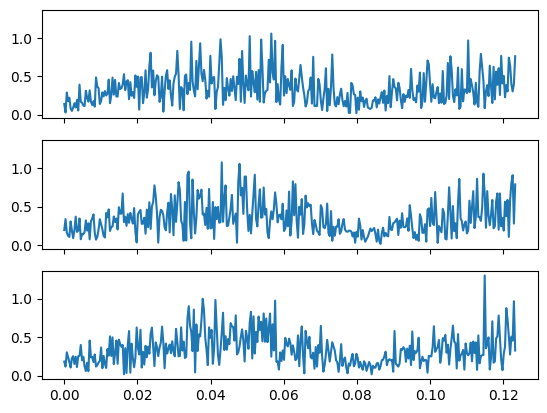

In [39]:
peak_value = np.zeros(3)
peak_index = np.zeros(3, 'int')
pssIndices = np.arange((119-63), (119+64))
fig, axs = plt.subplots(3, 1, facecolor='w', sharex=True, sharey=True)
for current_NID2 in np.arange(3, dtype='int'):
    slotGrid = nrResourceGrid(carrier)
    slotGrid = slotGrid[:, 0]
    slotGrid[pssIndices] = nrPSS(current_NID2)
    [refWaveform, info] = nrOFDMModulate(carrier, slotGrid, SampleRate = fs)
    refWaveform = refWaveform[info['CyclicPrefixLengths'][0]:]; # remove CP

    temp = scipy.signal.correlate(waveform[:int(25e-3 * fs)], refWaveform, 'valid')  # correlate over 25 ms
    peak_index[current_NID2] = np.argmax(np.abs(temp))
    peak_value[current_NID2] = np.abs(temp[peak_index[current_NID2]])
    t_corr = np.arange(temp.shape[0])/fs*1e3
    axs[current_NID2].plot(t_corr, np.abs(temp))
detected_NID2 = np.argmax(peak_value)
print(f'detected NID2 is {detected_NID2}')
plt.show()